# Personal vs Promotional: Modeling Mompreneur Narratives in #SAHM TikTok
Ruth Jin — Dec. 23, 2025
### Background
Mothers who run home-based businesses (mompreneurs) use TikTok not only to share daily life but also to promote products, services, and income opportunities. The #SAHM (Stay-At-Home Mom) community has become a major hub for these creators, blending personal narratives about motherhood with entrepreneurial messaging. Prior research shows that social media narratives often mix emotional storytelling with promotional intent, shaping audience trust and engagement (Abidin, 2016). However, little work has examined how mompreneur creators specifically navigate the line between personal storytelling and promotional content, especially at scale.\
\
My research uses large-scale text analysis and machine-learning classification to distinguish personal vs promotional storytelling styles in #SAHM mompreneur TikTok posts. I will evaluate how these styles relate to audience engagement, how they vary across creators, and how they have changed over time from 2018–2025.

### Research Question
How do mompreneur creators within the #SAHM TikTok community balance personal and promotional storytelling content, and how does this balance relate to audience engagement at the creator level?


### Sub Questions
**Descriptive**: How frequently do mompreneur creators adopt personal, promotional, or mixed storytelling styles in posts, and how does the degree of mixing vary across creators?\
**Predictive**: To what extent does the degree of promotional storytelling (measured continuously) predict engagement outcomes for mompreneur posts and creators?

## Public Notebook (B) overview
- This notebook contains only public-safe analysis using three sanitized CSV files generated in Notebook A (private)
- Notebook A performed all steps that required sensitive TikTok information (usernames, raw captions, voice-to-text, and full text used for training).
- Notebook B uses only:
    - hashed creator/post IDs
    - engagement counts and derived rates
    - derived lexical hit counts
    - model outputs (predicted labels + promotional probabilities)
- This structure is necessary because the core project depends on creator identities and text content, which cannot be shared publicly.

## Table of Contents
1. [Load public-safe artifacts (from Notebook A)](#Load-Data)
2. [Data overview + privacy checks](#Data-Overview)
3. [Figure 1 — Text length distributions (caption vs caption+VT)](#Figure-1---Text-length-distributions)
4. [Table 1 — Classifier comparison (caption-only vs caption+VT)](#Table-1---Classifier-comparison-(caption-only-vs-caption+VT))
5. [Figure 2 — Human validation confusion matrix](#Figure-2---Human-validation-confusion-matrix)
6. [Figure 3 — Distribution of creator promotional probability](#Figure-3---Distribution-of-creator-promotional-probability)
7. [Figure 4 — Creator trajectories (random sample from top-K increasers)](#Figure-4---Creator-trajectories-(random-sample-from-top-K-increasers))
8. [Figure 5 — Promotional emphasis vs engagement + reach (side-by-side)](#Figure-5---Promotional-emphasis-vs-engagement-+-reach-(side-by-side))
9. [OLS regression — Promotional probability predicting engagement](#OLS-regression-+-export-coefficient-table)

## Load Data

In [50]:
# -----------------------------
# 1) IMPORTS
# -----------------------------

import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [47]:
# -----------------------------
# 2) PATHS (public-safe outputs from Notebook A)
# -----------------------------

# Paths to public-safe artifacts produced in Notebook A (Private notebook that include user-sensitive information)
# Notebook A generated these sanitized files by removing usernames + raw text and hashing IDs.
POST_PATH = "data_sanitized/post_level_sanitized.csv"
CREATOR_PATH = "data_sanitized/creator_stats.csv"
CREATOR_YEAR_PATH = "data_sanitized/creator_year_stats.csv"
METRICS_PATH = "data_sanitized/model_metrics.csv"
HUMAN_CM_PATH = "data_sanitized/human_validation_confusion.csv"

In [48]:
# -----------------------------
# 3) LOAD DATA
# -----------------------------

df_posts = pd.read_csv(POST_PATH) # post-level rows (hashed post/creator IDs)
df_creator = pd.read_csv(CREATOR_PATH) # creator-level aggregation table
df_creator_year = pd.read_csv(CREATOR_YEAR_PATH) # creator-year time series table

# Load optional artifacts Notebook A produced that I might use
model_metrics = pd.read_csv(METRICS_PATH) if os.path.exists(METRICS_PATH) else None
human_cm = pd.read_csv(HUMAN_CM_PATH) if os.path.exists(HUMAN_CM_PATH) else None

In [49]:
# -----------------------------
# 4) OUTPUT DIRECTORIES
# -----------------------------

# Figures and tables saved by Notebook B
os.makedirs("figures", exist_ok=True)
os.makedirs("tables", exist_ok=True)

In [51]:
# -----------------------------
# 5) QUICK SHAPE CHECK
# -----------------------------

print("posts:", df_posts.shape)
print("creator:", df_creator.shape)
print("creator_year:", df_creator_year.shape)
print("metrics:", None if model_metrics is None else model_metrics.shape)
print("human_cm:", None if human_cm is None else human_cm.shape)

posts: (48971, 17)
creator: (5510, 7)
creator_year: (6843, 5)
metrics: (2, 7)
human_cm: (1, 7)


## Data Overview

What this section does:
- Shows a small preview of each public-safe dataset (shape, columns, head)
- Confirms there are no restricted columns (e.g., username, captions, VT text)

What Notebook A did privately:
- Loaded raw TikTok data including usernames + captions + voice-to-text
- Built training labels, trained the classifier, applied it to all posts
- Dropped all restricted columns before exporting these CSVs

In [56]:
# -----------------------------
# 1) DEFINE RESTRICTED (PRIVATE) FIELDS THAT SHOULD NEVER APPEAR HERE
# -----------------------------

RESTRICTED_COLS = {
    "username", "id", "video_description", "voice_to_text",
    "text_desc", "text_vt", "text_all", "text_desc_only"
}

def assert_no_restricted_cols(df, df_name):
    """
    Verify that no sensitive columns appear in the public artifacts.
    Raises an error if any restricted column is found.
    """
    leaks = RESTRICTED_COLS.intersection(df.columns)  # overlap between restricted and present columns
    if leaks:
        raise ValueError(f"{df_name} contains restricted columns: {sorted(leaks)}")
    print(f"{df_name}: no restricted columns found.")

# Run checks
assert_no_restricted_cols(df_posts, "df_posts")
assert_no_restricted_cols(df_creator, "df_creator")
assert_no_restricted_cols(df_creator_year, "df_creator_year")

df_posts: no restricted columns found.
df_creator: no restricted columns found.
df_creator_year: no restricted columns found.


In [57]:
# -----------------------------
# 2) COMPACT OVERVIEW FUNCTION
# -----------------------------

def quick_overview(df, name, max_cols=30):
    """Print a compact overview (shape, columns, head, missingness)."""
    print(f"\n--- {name} ---")
    print("shape:", df.shape)  # number of rows, columns
    cols = list(df.columns)
    print("columns:", cols[:max_cols], ("..." if len(cols) > max_cols else ""))  # avoid huge dumps

    print("\nhead():")
    display(df.head())

    print("\nmissing values (top 10):")
    display(df.isna().sum().sort_values(ascending=False).head(10))  # highlight missingness

# Show overview for each dataset
quick_overview(df_posts, "Post-level sanitized data (df_posts)")
quick_overview(df_creator, "Creator-level stats (df_creator)")
quick_overview(df_creator_year, "Creator-year stats (df_creator_year)")


--- Post-level sanitized data (df_posts) ---
shape: (48971, 17)
columns: ['post_key', 'creator_id', 'year', 'view_count', 'like_count', 'comment_count', 'share_count', 'n_words_desc', 'n_words_vt', 'n_words_desc_vt', 'has_mompreneur_tag', 'promo_hits', 'personal_hits', 'p_promotional', 'style_pred', 'like_rate', 'like_rate_w'] 

head():


,post_key,creator_id,year,view_count,like_count,comment_count,share_count,n_words_desc,n_words_vt,n_words_desc_vt,has_mompreneur_tag,promo_hits,personal_hits,p_promotional,style_pred,like_rate,like_rate_w
0,c7331c0d31,383e82fc59,2021,54375,6036,47.0,49,11,24,35,False,0,0,0.123984,personal,0.111007,0.111007
1,96f2655d2d,da84d77a93,2021,103765,5240,231.0,119,15,21,36,True,0,0,0.098284,personal,0.050499,0.050499
2,0ffd88e8c5,b4d840561f,2021,1167,74,2.0,4,11,210,221,True,0,1,0.545505,promotional,0.063410,0.063410
3,3b3195b261,154b1e4547,2021,7369,301,32.0,30,25,87,112,False,0,0,0.242480,personal,0.040847,0.040847
4,371a0e16c2,764dee172a,2021,51491,4165,43.0,4,20,60,80,False,0,0,0.302819,personal,0.080888,0.080888



missing values (top 10):


like_rate_w           367
like_rate             367
comment_count          96
n_words_desc_vt         0
style_pred              0
p_promotional           0
personal_hits           0
promo_hits              0
has_mompreneur_tag      0
post_key                0
dtype: int64


--- Creator-level stats (df_creator) ---
shape: (5510, 7)
columns: ['creator_id', 'total_posts', 'mean_p_promotional', 'frac_pred_promotional', 'median_like_rate', 'mean_like_rate', 'median_words'] 

head():


,creator_id,total_posts,mean_p_promotional,frac_pred_promotional,median_like_rate,mean_like_rate,median_words
0,0003c5b820,6,0.649564,0.666667,0.033708,0.038613,242.5
1,0013f33713,5,0.702159,0.800000,0.034483,0.032011,268.0
2,001b777bd6,1,0.240431,0.000000,0.004525,0.004525,530.0
3,0037b7274e,3,0.350042,0.000000,0.043077,0.031296,62.0
4,00409daea1,1,0.209145,0.000000,0.066993,0.066993,345.0



missing values (top 10):


median_like_rate         13
mean_like_rate           13
creator_id                0
total_posts               0
mean_p_promotional        0
frac_pred_promotional     0
median_words              0
dtype: int64


--- Creator-year stats (df_creator_year) ---
shape: (6843, 5)
columns: ['creator_id', 'year', 'n_posts', 'frac_promotional', 'mean_p_promotional'] 

head():


,creator_id,year,n_posts,frac_promotional,mean_p_promotional
0,0003c5b820,2023,6,0.666667,0.649564
1,0013f33713,2024,5,0.800000,0.702159
2,001b777bd6,2023,1,0.000000,0.240431
3,0037b7274e,2023,1,0.000000,0.369856
4,0037b7274e,2024,2,0.000000,0.340135



missing values (top 10):


creator_id            0
year                  0
n_posts               0
frac_promotional      0
mean_p_promotional    0
dtype: int64

In [58]:
# -----------------------------
# 3) CURATED PREVIEW FOR READABILITY
# -----------------------------

post_preview_cols = [
    "post_key", "creator_id", "year",
    "view_count", "like_count", "comment_count", "share_count",
    "n_words_desc", "n_words_vt", "n_words_desc_vt",
    "promo_hits", "personal_hits", "p_promotional", "style_pred"
]

# Keep only columns that exist
post_preview_cols = [c for c in post_preview_cols if c in df_posts.columns]

print("\nCurated post-level preview columns:", post_preview_cols)
display(df_posts[post_preview_cols].head(10))


Curated post-level preview columns: ['post_key', 'creator_id', 'year', 'view_count', 'like_count', 'comment_count', 'share_count', 'n_words_desc', 'n_words_vt', 'n_words_desc_vt', 'promo_hits', 'personal_hits', 'p_promotional', 'style_pred']


,post_key,creator_id,year,view_count,like_count,comment_count,share_count,n_words_desc,n_words_vt,n_words_desc_vt,promo_hits,personal_hits,p_promotional,style_pred
0,c7331c0d31,383e82fc59,2021,54375,6036,47.0,49,11,24,35,0,0,0.123984,personal
1,96f2655d2d,da84d77a93,2021,103765,5240,231.0,119,15,21,36,0,0,0.098284,personal
2,0ffd88e8c5,b4d840561f,2021,1167,74,2.0,4,11,210,221,0,1,0.545505,promotional
3,3b3195b261,154b1e4547,2021,7369,301,32.0,30,25,87,112,0,0,0.242480,personal
4,371a0e16c2,764dee172a,2021,51491,4165,43.0,4,20,60,80,0,0,0.302819,personal
5,40ab51489e,b4d840561f,2021,5442,297,5.0,2,9,115,124,0,0,0.549849,promotional
6,835f09afcc,7ac509afbf,2021,436896,10552,190.0,637,16,26,42,0,0,0.294705,personal
7,9e96d7c765,d75b06bc8d,2021,0,0,132.0,0,17,199,216,0,0,0.120374,personal
8,e845abadec,f911d6fe0c,2021,4393,239,20.0,9,15,186,201,0,0,0.731399,promotional
9,b57b3ffe97,f911d6fe0c,2021,4940,257,19.0,4,29,54,83,0,0,0.494401,personal


## Figure 1 - Text length distributions

What this section does
- Recreates the plot comparing text lengths using:
    - caption-only word count (n_words_desc)
    - caption + voice-to-text word count (n_words_desc_vt)
- Uses log10(1 + words) to reduce skew\

What Notebook A did privately
- Constructed the combined text field text_all = caption + hashtags + voice_to_text
- Counted words in caption and voice-to-text separately, then saved word count columns to the sanitized CSV

In [62]:
# -----------------------------
# 1) LOG TRANSFORM WORD COUNTS (to reduce heavy tail)
# -----------------------------

df_posts["log_len_desc"] = np.log10(1 + df_posts["n_words_desc"].fillna(0))  # caption only
df_posts["log_len_desc_vt"] = np.log10(1 + df_posts["n_words_desc_vt"].fillna(0))  # caption + VT

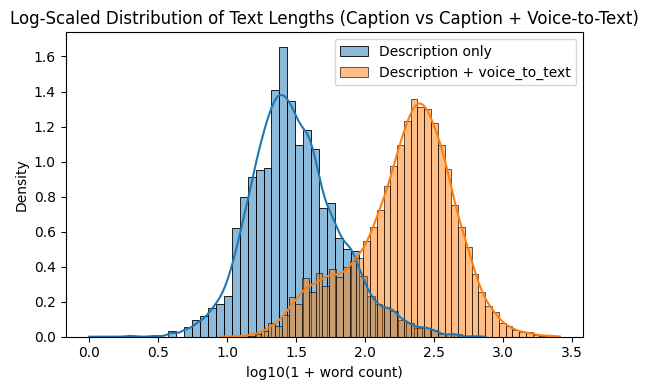

In [63]:
# -----------------------------
# 2) PLOT DISTRIBUTIONS
# -----------------------------

plt.figure(figsize=(6, 4))  # figure size
bins = 50  # histogram bins

# Caption-only distribution
sns.histplot(
    df_posts["log_len_desc"],
    bins=bins,
    stat="density",  # density rather than raw counts
    kde=True,  # smooth curve
    label="Description only",
    alpha=0.5,  # transparency
)

# Caption + VT distribution
sns.histplot(
    df_posts["log_len_desc_vt"],
    bins=bins,
    stat="density",
    kde=True,
    label="Description + voice_to_text",
    alpha=0.5,
)

# Labels and save
plt.title("Log-Scaled Distribution of Text Lengths (Caption vs Caption + Voice-to-Text)")
plt.xlabel("log10(1 + word count)")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.savefig("figures/fig1_text_length_distribution.png", dpi=300)  # save for repo
plt.show()


## Table 1 - Classifier comparison (caption-only vs caption+VT)

What this section does
- Loads the model performance table produced in Notebook A and formats it for display + export.

What Notebook A did privately
- Built weak labels using keyword lexicons, trained two TF-IDF + logistic regression models:
    - caption-only
    - caption + voice-to-text
- Evaluated on a stratified validation split and saved the metrics table as model_metrics.csv

In [65]:
# -----------------------------
# 1) SELECT + FORMAT COLUMNS
# -----------------------------
table1 = model_metrics[[
    "model",              # model name
    "accuracy",           # overall accuracy
    "precision_promo",    # precision for the promotional class
    "recall_promo",       # recall for the promotional class
    "f1_promo",           # F1 for the promotional class
    "n_train",            # training size
    "n_val"               # validation size
    ]].copy()

# Round floats for readability
for col in ["accuracy", "precision_promo", "recall_promo", "f1_promo"]:
    table1[col] = pd.to_numeric(table1[col], errors="coerce").round(3)

In [66]:
# -----------------------------
# 3) DISPLAY + SAVE
# -----------------------------
display(table1)  # show in notebook
table1.to_csv("tables/table1_model_comparison.csv", index=False)  # save for repo
print("Saved: tables/table1_model_comparison.csv")

,model,accuracy,precision_promo,recall_promo,f1_promo,n_train,n_val
0,caption_only,0.925,0.607,0.891,0.722,17179,4295
1,caption_plus_vt,0.971,0.819,0.944,0.877,17179,4295


Saved: tables/table1_model_comparison.csv


## Figure 2 - Human validation confusion matrix

What this section does
- Visualizes the human validation results (200 labeled examples) as a confusion matrix.

What Notebook A did privately
- Sampled 200 posts (100 predicted personal, 100 predicted promotional), exported a private labeling sheet with text.
- After manual labeling, computed confusion matrix + Cohen’s kappa, and saved public-safe counts to human_validation_confusion.csv

In [60]:
from sklearn.metrics import ConfusionMatrixDisplay

In [67]:
# -----------------------------
# 2) EXTRACT COUNTS
# -----------------------------
row = human_cm.iloc[0]  # single-row table

tn = int(row["tn"])  # true personal predicted personal
fp = int(row["fp"])  # true personal predicted promotional
fn = int(row["fn"])  # true promotional predicted personal
tp = int(row["tp"])  # true promotional predicted promotional

acc = float(row.get("accuracy", np.nan))  # validation accuracy
kappa = float(row.get("kappa", np.nan))   # Cohen's kappa
n = int(row.get("n", tn + fp + fn + tp))  # sample size

# Build 2x2 matrix:
# rows = human label, columns = model prediction
cm = np.array([
    [tn, fp],
    [fn, tp]
    ])

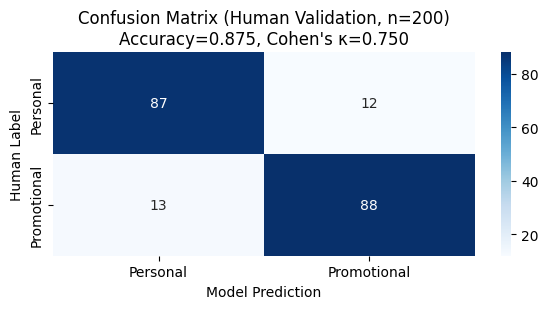

In [69]:
# -----------------------------
# 3) PLOT HEATMAP
# -----------------------------
plt.figure(figsize=(6, 3.2))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues", # show counts in cells
    xticklabels=["Personal", "Promotional"],
    yticklabels=["Personal", "Promotional"]
    )
plt.title(f"Confusion Matrix (Human Validation, n={n})\nAccuracy={acc:.3f}, Cohen's κ={kappa:.3f}")
plt.xlabel("Model Prediction")
plt.ylabel("Human Label")
plt.tight_layout()
plt.savefig("figures/fig2_confusion_matrix.png", dpi=300)
plt.show()

## Figure 3 - Distribution of creator promotional probability

What this section does
- Plots the distribution of mean promotional probability across creators.

What Notebook A did privately
- Applied the final VT-based classifier to all mompreneur posts, producing post-level p_promotional.
- Aggregated to creator level: mean_p_promotional per creator, then saved into creator_stats.csv

In [70]:
# -----------------------------
# 1) EXTRACT MEAN PROMOTIONAL PROBABILITY
# -----------------------------
x = pd.to_numeric(df_creator["mean_p_promotional"], errors="coerce").dropna()

# Summary stats for annotation
q50 = float(x.median())  # median
mean_val = float(x.mean())  # mean

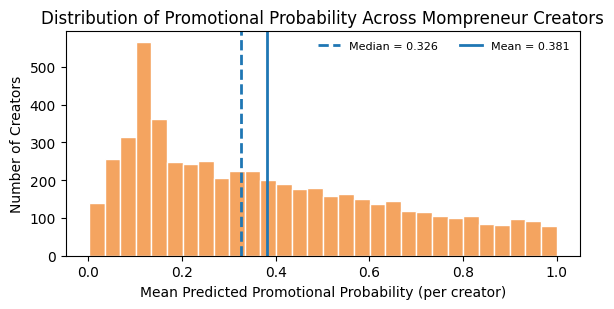

In [72]:
# -----------------------------
# 2) PLOT HISTOGRAM
# -----------------------------
plt.figure(figsize=(6, 3.2))

plt.hist(
    x,
    bins=30,
    edgecolor="white",  # helps visually separate bars
    color="sandybrown"
)

# Add vertical lines for mean and median
plt.axvline(q50, linestyle="--", linewidth=2, label=f"Median = {q50:.3f}")
plt.axvline(mean_val, linestyle="-", linewidth=2, label=f"Mean = {mean_val:.3f}")

# Labels and save
plt.title("Distribution of Promotional Probability Across Mompreneur Creators")
plt.xlabel("Mean Predicted Promotional Probability (per creator)")
plt.ylabel("Number of Creators")
plt.legend(frameon=False, fontsize=8, ncol=2)

plt.tight_layout()
plt.savefig("figures/fig3_creator_promo_prob_hist.png", dpi=300)
plt.show()

## Figure 4 - Creator trajectories (random sample from top-K increasers)

What this section does
- Finds creators whose promotional share increases the most over time.
- Takes the top-K by increase, then uses a fixed random seed to sample 8.
- Plots promotional fraction over time as small multiples.

What Notebook A did privately
- Generated creator_year_stats.csv, including per-year frac_promotional (share of posts predicted promotional).
- Notebook B only uses the time series table; no usernames or text are involved.

In [73]:
def plot_small_multiples(creator_ids, title, subtitle_df=None):
    """
    Plot creator-year trajectories for a list of creator_ids.

    Parameters:
    - creator_ids (list[str]): hashed creator ids to plot
    - title (str): figure title
    - subtitle_df (pd.DataFrame or None): optional df with creator_id and extra columns
      (e.g., delta_frac, total_posts) used for subplot titles

    Returns:
    - fig (matplotlib.figure.Figure): the figure object for saving
    """
    # Subset the creator-year time series to only the selected creators
    plot_df = df_creator_year[df_creator_year["creator_id"].isin(creator_ids)].copy()

    # Sort so the line plots connect years in order
    plot_df = plot_df.sort_values(["creator_id", "year"])

    # Layout: 4 columns, enough rows to fit all creators
    cols = 4
    rows = math.ceil(len(creator_ids) / cols)

    # Create subplots; share axes for comparability
    fig, axes = plt.subplots(
        rows,
        cols,
        figsize=(12, 3 * rows),
        sharex=True,
        sharey=True
    )

    # Flatten axes to 1D for easy indexing
    axes = np.array(axes).reshape(-1)

    # If subtitles provided, convert to dict keyed by creator_id
    subtitle_map = None
    if subtitle_df is not None:
        subtitle_map = subtitle_df.set_index("creator_id").to_dict(orient="index")

    # Plot each creator in its own panel
    for i, cid in enumerate(creator_ids):
        ax = axes[i]  # current subplot axis

        # Extract this creator's time series
        d = plot_df[plot_df["creator_id"] == cid]

        # Line plot of promotional fraction over time
        ax.plot(
            d["year"],
            d["frac_promotional"],
            marker="o",
            linewidth=1.5
        )

        # Consistent y-limits since fraction is between 0 and 1
        ax.set_ylim(0, 1)

        # Light grid
        ax.grid(alpha=0.2)

        # Build subplot label
        label = f"creator_{cid}"

        # Add subtitle stats if available
        if subtitle_map is not None and cid in subtitle_map:
            row = subtitle_map[cid]
            if "delta_frac" in row:
                label += f"\nΔ={row['delta_frac']:.2f}"
            if "total_posts" in row:
                label += f" | posts={int(row['total_posts'])}"

        ax.set_title(label, fontsize=9)

    # Turn off any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    # Main title (slightly above the grid)
    fig.suptitle(title, y=1.02, fontsize=14)

    plt.tight_layout()  # compact layout
    return fig

In [74]:
# -----------------------------
# 1) SETTINGS
# -----------------------------
TOP_N = 8         # number of creators to plot
K = 50            # size of the "top pool" to sample from
SEED = 133        # fixed seed for reproducible randomness

# Filters to avoid very sparse/noisy creator histories
MIN_TOTAL_POSTS = 20  # creator must have >= this many posts across all years
MIN_YEARS = 3         # creator must appear in >= this many distinct years
MIN_DELTA = 0.20      # creator must increase promo fraction by at least this much

In [75]:
# -----------------------------
# 2) COMPUTE CREATOR TOTALS (posts + years)
# -----------------------------
creator_totals = (
    df_creator_year
    .groupby("creator_id")
    .agg(
        total_posts=("n_posts", "sum"),   # total posts across years
        n_years=("year", "nunique")       # distinct years observed
    )
    .reset_index()
)

In [76]:
# -----------------------------
# 3) RESTRICT TO ELIGIBLE CREATORS
# -----------------------------
eligible_ids = creator_totals.loc[
    (creator_totals["total_posts"] >= MIN_TOTAL_POSTS) &
    (creator_totals["n_years"] >= MIN_YEARS),
    "creator_id"
]

# Filter creator-year trajectories down to eligible creators
cy = df_creator_year[df_creator_year["creator_id"].isin(eligible_ids)].copy()

# Sort so "first" and "last" are meaningful
cy = cy.sort_values(["creator_id", "year"])

In [77]:
# -----------------------------
# 4) COMPUTE DELTA: last frac_promotional - first frac_promotional
# -----------------------------
first = cy.groupby("creator_id").first().reset_index()  # earliest year per creator
last = cy.groupby("creator_id").last().reset_index()    # latest year per creator

trend = first[["creator_id", "frac_promotional"]].merge(
    last[["creator_id", "frac_promotional"]],
    on="creator_id",
    suffixes=("_first", "_last")
)

# Add totals back in
trend = trend.merge(creator_totals, on="creator_id", how="left")

# Compute change over time
trend["delta_frac"] = trend["frac_promotional_last"] - trend["frac_promotional_first"]

# Keep creators with at least MIN_DELTA increase
trend = trend[trend["delta_frac"] >= MIN_DELTA].copy()

In [78]:
# -----------------------------
# 5) TAKE TOP-K BY DELTA (tie-break by total_posts)
# -----------------------------
topK = (
    trend
    .sort_values(["delta_frac", "total_posts"], ascending=[False, False])
    .head(K)
    .copy()
)

# Pool of creator_ids to sample from
pool = topK["creator_id"].to_numpy()

# Defensive check
if len(pool) < TOP_N:
    raise ValueError(
        f"Top-K pool too small ({len(pool)}) for TOP_N={TOP_N}. "
        "Try lowering MIN_DELTA/MIN_YEARS/MIN_TOTAL_POSTS or increasing K."
    )

In [79]:
# -----------------------------
# 6) SEEDED RANDOM SAMPLE FROM THE TOP-K POOL
# -----------------------------
rng = np.random.default_rng(SEED)  # reproducible RNG
picked_change = rng.choice(pool, size=TOP_N, replace=False).tolist()  # sample without replacement

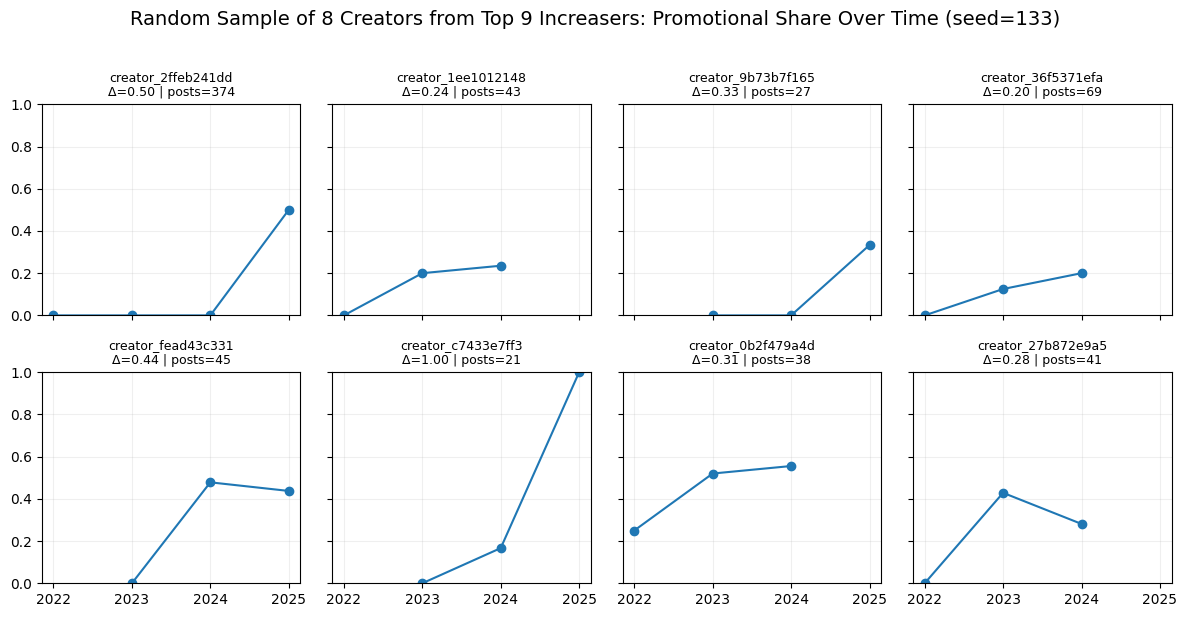

In [80]:
# -----------------------------
# 7) PLOT
# -----------------------------
fig = plot_small_multiples(
    picked_change,
    title=(
        f"Random Sample of {TOP_N} Creators from Top {min(K, len(pool))} Increasers: "
        f"Promotional Share Over Time (seed={SEED})"
    ),
    subtitle_df=topK[["creator_id", "delta_frac", "total_posts"]]  # show Δ + post counts in subtitles
)

# Save for repo
fig.savefig("figures/fig4_creator_trajectories_topK_random.png", dpi=300, bbox_inches="tight")

# Display
plt.show()

## Figure 5 - Promotional emphasis vs engagement + reach (side-by-side)

What this section does
- Builds two side-by-side scatterplots at the creator level:
    1. mean promotional probability vs median like rate (log1p)
    2. mean promotional probability vs median views (log1p)
- Adds a fitted red regression line + equation in each panel.

What Notebook A did privately
- Created creator-level summaries (mean promo probability, median like rate, total posts, median words).
- Notebook B merges in median views using the sanitized post-level file.

In [81]:
# -----------------------------
# 1) BUILD REGRESSION/PLOT DATASET
# -----------------------------
df_reg = df_creator.copy()  # start from creator-level table

# Ensure numeric typing for the fields we need
for c in ["mean_p_promotional", "total_posts", "median_like_rate", "median_words"]:
    df_reg[c] = pd.to_numeric(df_reg[c], errors="coerce")

# Drop rows with missing essentials
df_reg = df_reg.dropna(subset=["mean_p_promotional", "total_posts", "median_like_rate", "median_words"]).copy()

In [82]:
# -----------------------------
# 2) ENSURE MEDIAN VIEWS EXISTS (compute from post-level)
# -----------------------------
# The creator-level table doesn't always include view summaries
creator_views = (
    df_posts.assign(view_count=pd.to_numeric(df_posts["view_count"], errors="coerce"))  # ensure numeric
    .groupby("creator_id")["view_count"]
    .median()  # creator median views across posts
    .reset_index()
    .rename(columns={"view_count": "median_views"})
)

# Merge into df_reg
df_reg = df_reg.merge(creator_views, on="creator_id", how="left")

# Convert views to numeric
df_reg["median_views"] = pd.to_numeric(df_reg["median_views"], errors="coerce")

In [83]:
# -----------------------------
# 3) TRANSFORMS (log(1 + x)) FOR SKEWED OUTCOMES
# -----------------------------
df_reg["log1p_median_like_rate"] = np.log1p(df_reg["median_like_rate"])  # engagement rate
df_reg["log1p_median_views"] = np.log1p(df_reg["median_views"])          # reach

# Drop missing transformed values
plot_df = df_reg.dropna(subset=["mean_p_promotional", "log1p_median_like_rate", "log1p_median_views"]).copy()

In [84]:
# -----------------------------
# 4) FIT LINE HELPERS
# -----------------------------
def fit_line_and_eq(x, y):
    """
    Fit a least-squares line y = m x + b and return:
    - m (slope)
    - b (intercept)
    - formatted equation string
    """
    m, b = np.polyfit(x, y, 1)  # degree-1 polynomial fit
    return m, b, f"y = {m:.3f}x + {b:.3f}"

# Extract x and y arrays
x = plot_df["mean_p_promotional"].values  # mean promotional probability per creator

y_like = plot_df["log1p_median_like_rate"].values  # log(1 + median like rate)
m1, b1, eq1 = fit_line_and_eq(x, y_like)

y_views = plot_df["log1p_median_views"].values  # log(1 + median views)
m2, b2, eq2 = fit_line_and_eq(x, y_views)

# x-values for the fitted line
x_line = np.linspace(np.nanmin(x), np.nanmax(x), 200)

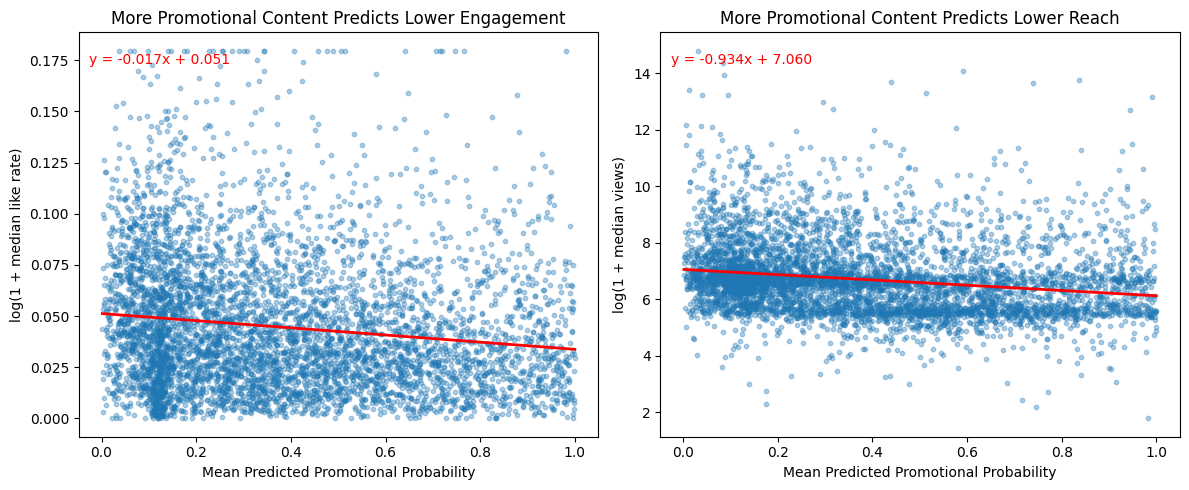

In [85]:
# -----------------------------
# 5) PLOT SIDE-BY-SIDE
# -----------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

# Panel A: Like rate
axes[0].scatter(x, y_like, alpha=0.35, s=10)  # scatter points
axes[0].plot(x_line, m1 * x_line + b1, color="red", linewidth=2)  # fitted line
axes[0].set_title("More Promotional Content Predicts Lower Engagement")
axes[0].set_xlabel("Mean Predicted Promotional Probability")
axes[0].set_ylabel("log(1 + median like rate)")
axes[0].text(
    0.02, 0.95, eq1,
    transform=axes[0].transAxes,  # place relative to axes
    va="top", ha="left",
    color="red", fontsize=10
)

# Panel B: Views
axes[1].scatter(x, y_views, alpha=0.35, s=10)
axes[1].plot(x_line, m2 * x_line + b2, color="red", linewidth=2)
axes[1].set_title("More Promotional Content Predicts Lower Reach")
axes[1].set_xlabel("Mean Predicted Promotional Probability")
axes[1].set_ylabel("log(1 + median views)")
axes[1].text(
    0.02, 0.95, eq2,
    transform=axes[1].transAxes,
    va="top", ha="left",
    color="red", fontsize=10
)

plt.tight_layout()
plt.savefig("figures/fig5_promo_vs_like_and_views.png", dpi=300)
plt.show()


## OLS regression + export coefficient table

In [86]:
# -----------------------------
# 1) DEFINE OUTCOME (Y)
# -----------------------------
y = df_reg["log1p_median_like_rate"]  # log(1 + median like rate)

In [87]:
# -----------------------------
# 2) DEFINE PREDICTORS (X)
# -----------------------------
X = df_reg[["mean_p_promotional", "total_posts", "median_words"]].copy()

# Log-transform total posts to reduce skew in posting volume
X["log1p_total_posts"] = np.log1p(X["total_posts"])

# Drop raw total_posts (keep log version)
X = X.drop(columns=["total_posts"])

# Add intercept term
X = sm.add_constant(X)

In [88]:
# -----------------------------
# 3) FIT OLS
# -----------------------------
model = sm.OLS(y, X, missing="drop").fit()

# Print the full statsmodels summary
print(model.summary())

                              OLS Regression Results                              
Dep. Variable:     log1p_median_like_rate   R-squared:                       0.033
Model:                                OLS   Adj. R-squared:                  0.032
Method:                     Least Squares   F-statistic:                     62.41
Date:                    Mon, 22 Dec 2025   Prob (F-statistic):           1.13e-39
Time:                            18:41:05   Log-Likelihood:                 11144.
No. Observations:                    5497   AIC:                        -2.228e+04
Df Residuals:                        5493   BIC:                        -2.225e+04
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------

In [89]:
# -----------------------------
# 4) SAVE CLEAN COEFFICIENT TABLE
# -----------------------------
coef_table = pd.DataFrame({
    "term": model.params.index,     # predictor name
    "coef": model.params.values,    # coefficient estimate
    "se": model.bse.values,         # standard error
    "t": model.tvalues.values,      # t-statistic
    "p": model.pvalues.values,      # p-value
})

# Save for repo
coef_table.to_csv("tables/ols_creator_engagement.csv", index=False)
print("Saved: tables/ols_creator_engagement.csv")

# Display in notebook
display(coef_table)

Saved: tables/ols_creator_engagement.csv


,term,coef,se,t,p
0,const,0.044608,0.001091,40.891440,0.000000e+00
1,mean_p_promotional,-0.017987,0.001693,-10.621124,4.251442e-26
2,median_words,0.000010,0.000003,3.462944,5.383748e-04
3,log1p_total_posts,0.003118,0.000432,7.210878,6.311718e-13


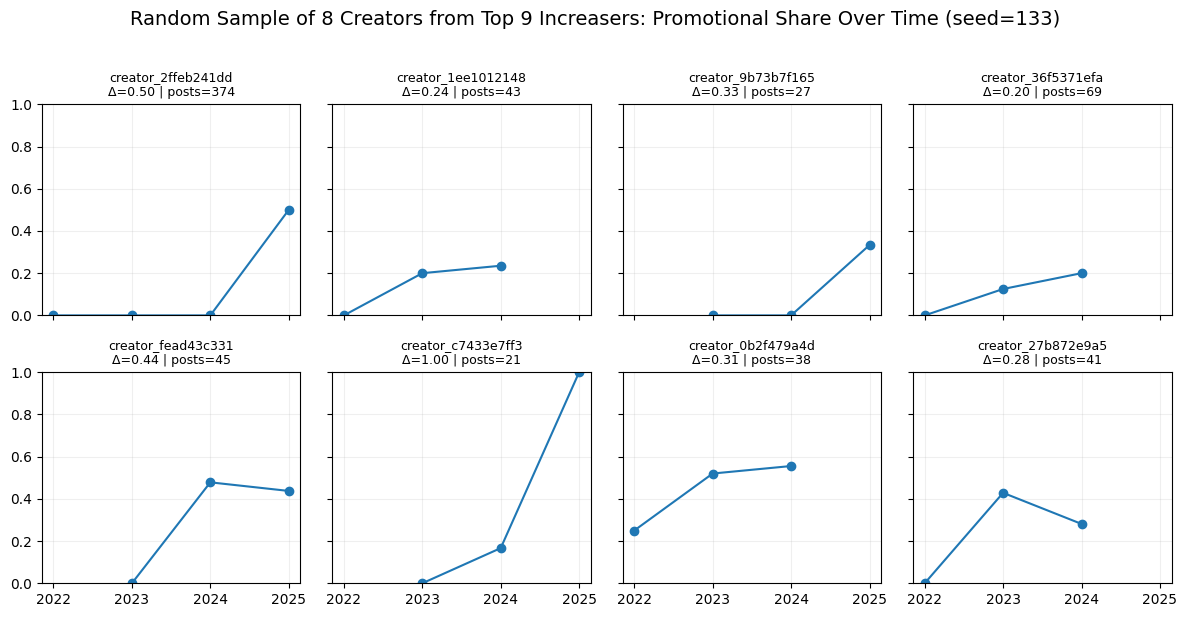

In [37]:
# How many creators to plot (8 panels total)
TOP_N = 8

# Define the size of the "top pool" we sample from.
# We'll rank creators by increase in promotional share, take the top K,
# then randomly sample TOP_N creators from that top-K pool.
K = 50

# Random seed for reproducibility (same seed => same sampled creators)
SEED = 133

# Eligibility filters (to avoid very sparse/noisy creator trajectories)
MIN_TOTAL_POSTS = 20  # creator must have at least this many posts total across years
MIN_YEARS = 3         # creator must appear in at least this many distinct years
MIN_DELTA = 0.20      # creator must have promo share change by at least this amount (0 to 1 scale)

# ---------------------------
# 1) Compute total posts + number of active years per creator
# ---------------------------
creator_totals = (
    df_creator_year
    .groupby("creator_id")  # one row per creator_id
    .agg(
        total_posts=("n_posts", "sum"),  # sum posts across all years
        n_years=("year", "nunique")      # count distinct years observed
    )
    .reset_index()
)

# ---------------------------
# 2) Restrict to "eligible" creators who have enough posts + enough years
# ---------------------------
eligible_ids = creator_totals.loc[
    (creator_totals["total_posts"] >= MIN_TOTAL_POSTS) &
    (creator_totals["n_years"] >= MIN_YEARS),
    "creator_id"
]

# Keep only the eligible creators in the creator-year time series table
cy = df_creator_year[df_creator_year["creator_id"].isin(eligible_ids)].copy()

# Sort so that "first" and "last" year per creator are well-defined
cy = cy.sort_values(["creator_id", "year"])

# ---------------------------
# 3) Compute each creator’s change in promotional fraction:
#    delta_frac = (last year frac_promotional) - (first year frac_promotional)
# ---------------------------

# For each creator, grab the first year row (earliest year after sorting)
first = cy.groupby("creator_id").first().reset_index()

# For each creator, grab the last year row (latest year after sorting)
last = cy.groupby("creator_id").last().reset_index()

# Merge first + last to put them on the same row per creator_id
trend = first[["creator_id", "frac_promotional"]].merge(
    last[["creator_id", "frac_promotional"]],
    on="creator_id",
    suffixes=("_first", "_last")  # rename columns so we can distinguish
)

# Add creator totals (posts/years) to this per-creator trend table
trend = trend.merge(creator_totals, on="creator_id", how="left")

# Compute change in promo share from first to last year
trend["delta_frac"] = trend["frac_promotional_last"] - trend["frac_promotional_first"]

# Optionally restrict to creators with at least MIN_DELTA increase
# (If you want a purely top-K without a hard cutoff, delete this next line.)
trend = trend[trend["delta_frac"] >= MIN_DELTA].copy()

# ---------------------------
# 4) Rank creators by delta (and tie-break by total posts), take top K,
#    then randomly sample TOP_N creators from that set
# ---------------------------

# Sort descending: biggest increase first; if tied, prefer higher total_posts
topK = (
    trend
    .sort_values(["delta_frac", "total_posts"], ascending=[False, False])
    .head(K)
    .copy()
)

# Extract the creator_id pool we will sample from
pool = topK["creator_id"].to_numpy()

# Defensive check: ensure we can sample TOP_N unique creators
if len(pool) < TOP_N:
    raise ValueError(
        f"Top-K pool too small ({len(pool)}) for TOP_N={TOP_N}. "
        "Try lowering MIN_DELTA/MIN_YEARS/MIN_TOTAL_POSTS or increasing K."
    )

# Seeded RNG for reproducible "random" selection
rng = np.random.default_rng(SEED)

# Randomly pick TOP_N creator_ids from the top-K pool without replacement
picked_change = rng.choice(pool, size=TOP_N, replace=False).tolist()

# ---------------------------
# 5) Plot the selected creators using your existing plot_small_multiples
# ---------------------------

# Use the topK table for subtitles so we can display Δ and total_posts
fig = plot_small_multiples(
    picked_change,
    title=(
        f"Random Sample of {TOP_N} Creators from Top {min(K, len(pool))} Increasers: "
        f"Promotional Share Over Time (seed={SEED})"
    ),
    subtitle_df=topK[["creator_id", "delta_frac", "total_posts"]]
)

# Save figure to disk (public notebook output)
fig.savefig("figures/fig4_creator_trajectories_topK_random.png", dpi=300, bbox_inches="tight")

# Display the figure
plt.show()